In [75]:
import pandas as pd
from collections import Counter
from sklearn.preprocessing import MinMaxScaler
from matplotlib import pyplot as plt
import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader, random_split
import torch.optim as optim
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix
import math
import numpy as np

In [2]:
data = pd.read_csv('datasets/mood_dataset_preprocessed.csv')

In [3]:
data.head()

,id,time,mood,appCat.communication,appCat.other,sms,circumplex.valence,screen,appCat.entertainment,appCat.weather,...,appCat.game,appCat.office,call,appCat.builtin,appCat.finance,circumplex.arousal,activity,appCat.utilities,appCat.unknown,appCat.travel
0,AS14.01,2014-02-26 13:00:00,6.0,0.0,0.0,7.0,0.0,0.0,0.0,0.0,...,0.0,0.0,17.0,0.0,0.0,-1.0,0.0,0.0,0.0,0.0
1,AS14.01,2014-02-26 15:00:00,6.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,-1.0,0.0,0.0,0.0,0.0
2,AS14.01,2014-02-26 18:00:00,6.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,AS14.01,2014-02-26 21:00:00,7.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
4,AS14.01,2014-02-27 09:00:00,6.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,-2.0,0.0,0.0,0.0,0.0


In [4]:
data.fillna(0.0, inplace=True)

In [5]:
data['time'] = pd.to_datetime(data['time'])

In [6]:
result = data.groupby([data['time'].dt.date, 'id']).size().reset_index(name='count')

In [7]:
result

,time,id,count
0,2014-02-26,AS14.01,4
1,2014-02-27,AS14.01,3
2,2014-03-04,AS14.17,2
3,2014-03-05,AS14.08,3
4,2014-03-05,AS14.17,3
...,...,...,...
1263,2014-06-04,AS14.24,4
1264,2014-06-05,AS14.24,5
1265,2014-06-06,AS14.24,4
1266,2014-06-07,AS14.24,1


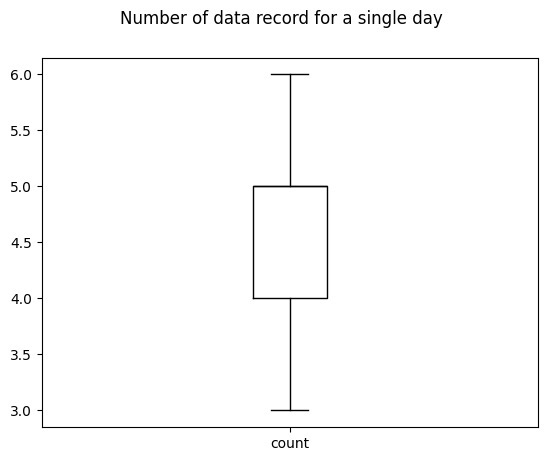

In [8]:
result.boxplot('count', grid=False, showfliers=False, color="black")
plt.suptitle("Number of data record for a single day")
plt.xlabel("")
plt.show()

In [9]:
data["next_mood"] = data.groupby('id')['mood'].shift(-1)

In [10]:
data.head(30)

,id,time,mood,appCat.communication,appCat.other,sms,circumplex.valence,screen,appCat.entertainment,appCat.weather,...,appCat.office,call,appCat.builtin,appCat.finance,circumplex.arousal,activity,appCat.utilities,appCat.unknown,appCat.travel,next_mood
0,AS14.01,2014-02-26 13:00:00,6.0,0.000,0.000,7.0,0.0,0.000000,0.000,0.000,...,0.000,17.0,0.000,0.000,-1.0,0.000000,0.000,0.000,0.000,6.0
1,AS14.01,2014-02-26 15:00:00,6.0,0.000,0.000,0.0,1.0,0.000000,0.000,0.000,...,0.000,0.0,0.000,0.000,-1.0,0.000000,0.000,0.000,0.000,6.0
2,AS14.01,2014-02-26 18:00:00,6.0,0.000,0.000,1.0,1.0,0.000000,0.000,0.000,...,0.000,0.0,0.000,0.000,0.0,0.000000,0.000,0.000,0.000,7.0
3,AS14.01,2014-02-26 21:00:00,7.0,0.000,0.000,0.0,1.0,0.000000,0.000,0.000,...,0.000,1.0,0.000,0.000,1.0,0.000000,0.000,0.000,0.000,6.0
4,AS14.01,2014-02-27 09:00:00,6.0,0.000,0.000,1.0,0.0,0.000000,0.000,0.000,...,0.000,0.0,0.000,0.000,-2.0,0.000000,0.000,0.000,0.000,6.0
5,AS14.01,2014-02-27 12:00:00,6.0,0.000,0.000,0.0,0.0,0.000000,0.000,0.000,...,0.000,0.0,0.000,0.000,1.0,0.000000,0.000,0.000,0.000,7.0
6,AS14.01,2014-02-27 15:00:00,7.0,0.000,0.000,0.0,1.0,0.000000,0.000,0.000,...,0.000,0.0,0.000,0.000,1.0,0.000000,0.000,0.000,0.000,6.0
7,AS14.01,2014-03-21 09:00:00,6.0,2300.541,11.345,10.0,0.0,4793.343000,350.856,0.000,...,0.000,33.0,496.208,0.000,-1.0,0.238190,302.689,45.173,0.000,6.0
8,AS14.01,2014-03-21 11:00:00,6.0,1794.749,38.160,0.0,0.0,4240.973000,403.980,0.000,...,0.000,0.0,587.566,18.196,0.0,0.065054,18.061,0.000,71.305,7.0
9,AS14.01,2014-03-21 15:00:00,7.0,1488.071,70.860,0.0,1.0,5467.570000,287.389,0.000,...,62.281,4.0,979.241,0.000,1.0,1.931720,154.724,0.000,844.140,6.0


In [11]:
average_moods = data.groupby('id')['mood'].mean()
data['next_mood'] = data.apply(
    lambda row: int(average_moods[row['id']]) if pd.isna(row['next_mood']) else int(row['next_mood']),
    axis=1
)

In [12]:
data.head()

,id,time,mood,appCat.communication,appCat.other,sms,circumplex.valence,screen,appCat.entertainment,appCat.weather,...,appCat.office,call,appCat.builtin,appCat.finance,circumplex.arousal,activity,appCat.utilities,appCat.unknown,appCat.travel,next_mood
0,AS14.01,2014-02-26 13:00:00,6.0,0.0,0.0,7.0,0.0,0.0,0.0,0.0,...,0.0,17.0,0.0,0.0,-1.0,0.0,0.0,0.0,0.0,6
1,AS14.01,2014-02-26 15:00:00,6.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,-1.0,0.0,0.0,0.0,0.0,6
2,AS14.01,2014-02-26 18:00:00,6.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,7
3,AS14.01,2014-02-26 21:00:00,7.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,6
4,AS14.01,2014-02-27 09:00:00,6.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,-2.0,0.0,0.0,0.0,0.0,6


In [13]:
features = ['mood', 'appCat.communication', 'appCat.other', 'sms',
       'circumplex.valence', 'screen', 'appCat.entertainment',
       'appCat.weather', 'appCat.social', 'appCat.game', 'appCat.office',
       'call', 'appCat.builtin', 'appCat.finance', 'circumplex.arousal',
       'activity', 'appCat.utilities', 'appCat.unknown', 'appCat.travel']
scaler = MinMaxScaler()
data[features] = scaler.fit_transform(data[features])

In [14]:
data.head()

,id,time,mood,appCat.communication,appCat.other,sms,circumplex.valence,screen,appCat.entertainment,appCat.weather,...,appCat.office,call,appCat.builtin,appCat.finance,circumplex.arousal,activity,appCat.utilities,appCat.unknown,appCat.travel,next_mood
0,AS14.01,2014-02-26 13:00:00,0.555556,0.0,0.0,0.084337,0.6,0.0,0.0,0.0,...,0.0,0.062044,0.7044,0.0,0.4,0.0,0.0,0.0,0.0,6
1,AS14.01,2014-02-26 15:00:00,0.555556,0.0,0.0,0.000000,0.8,0.0,0.0,0.0,...,0.0,0.000000,0.7044,0.0,0.4,0.0,0.0,0.0,0.0,6
2,AS14.01,2014-02-26 18:00:00,0.555556,0.0,0.0,0.012048,0.8,0.0,0.0,0.0,...,0.0,0.000000,0.7044,0.0,0.6,0.0,0.0,0.0,0.0,7
3,AS14.01,2014-02-26 21:00:00,0.666667,0.0,0.0,0.000000,0.8,0.0,0.0,0.0,...,0.0,0.003650,0.7044,0.0,0.8,0.0,0.0,0.0,0.0,6
4,AS14.01,2014-02-27 09:00:00,0.555556,0.0,0.0,0.012048,0.6,0.0,0.0,0.0,...,0.0,0.000000,0.7044,0.0,0.2,0.0,0.0,0.0,0.0,6


In [15]:
len(data)

5641

In [16]:
result = data.groupby([data['time'].dt.date, 'id']).apply(lambda x:  x.drop(columns=['time']).values.tolist(), include_groups=False).reset_index(drop=True)

In [17]:
len(result)

1268

In [18]:
MAX_LEN = 5

In [19]:
predictions = []
results = []

for single_data in result:
    if len(single_data) < MAX_LEN:
        n_fill = MAX_LEN - len(single_data)
        predictions.append(int(single_data[-1][-1]))
        while n_fill:
            single_data.append([0.0]*20)
            n_fill -= 1
    else:
        single_data = single_data[:MAX_LEN]
        predictions.append(int(single_data[-1][-1]))
    
    for single_record in single_data:
        del single_record[-1]
    
    results.append(single_data[:])    

In [20]:
for i in results:
    if len(i) != 5:
        print(len(i))

In [21]:
predictions = [i - 1 for i in predictions]

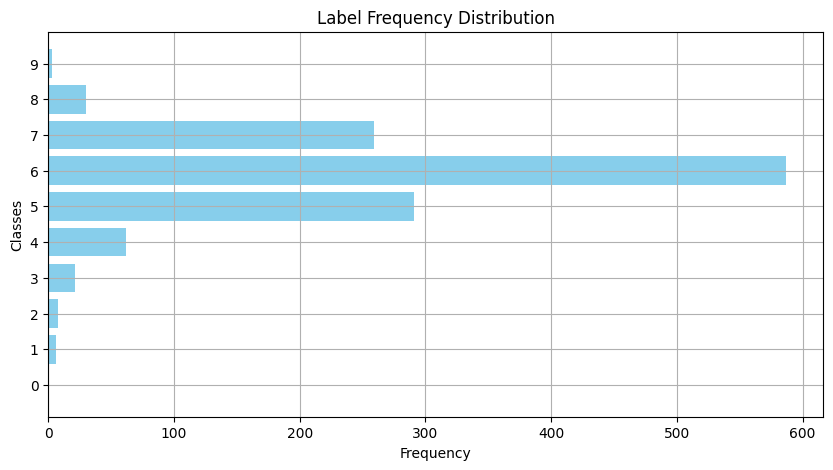

In [22]:
counter = Counter(predictions).most_common()
class_names = []
frequencies = []

for name, count in counter:
    class_names.append(name)
    frequencies.append(count)

plt.figure(figsize=(10, 5))
plt.barh(class_names, frequencies, color='skyblue')
plt.xlabel('Frequency')
plt.ylabel('Classes')
plt.yticks(range(10))
plt.title('Label Frequency Distribution')
plt.grid(True)
plt.show()

In [23]:
len(set(predictions))

10

In [35]:
data_tensor = torch.tensor(results, dtype=torch.float32)
labels_tensor = torch.tensor(predictions, dtype=torch.float32)

dataset = TensorDataset(data_tensor, labels_tensor)

In [36]:
total_samples = len(dataset)
train_size = int(0.8 * total_samples)
test_size = total_samples - train_size

In [37]:
train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

In [38]:
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

In [39]:
class MoodLSTMRegression(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_layers, output_dim):
        super(MoodLSTMRegression, self).__init__()
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers, batch_first=True)
        self.dropout = nn.Dropout(0.2)
        self.fc = nn.Linear(hidden_dim, output_dim)  # Output dimension is 10 for 10 classes
    
    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).to(x.device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).to(x.device)
        out, (_, _) = self.lstm(x, (h0.detach(), c0.detach()))
        
        out = self.dropout(out[:, -1, :])
        out = self.fc(out)
        return out

In [40]:
model = MoodLSTMRegression(input_dim=19, hidden_dim=10, num_layers=1, output_dim=1)

In [41]:
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.0005)

In [58]:
model.train()
loss_result = []
for epoch in range(100):
    for inputs, labels in train_loader:
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)  # No need to squeeze or convert labels
        loss.backward()
        optimizer.step()
        loss_result.append(loss.item())
        print(f"Epoch {epoch+1}, Loss: {loss.item()}")

/home/peter/Projects/data-mining-techniques-assignment1/venv/lib/python3.10/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([64])) that is different to the input size (torch.Size([64, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/home/peter/Projects/data-mining-techniques-assignment1/venv/lib/python3.10/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([54])) that is different to the input size (torch.Size([54, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch 1, Loss: 2.1795685291290283
Epoch 1, Loss: 1.9451910257339478
Epoch 1, Loss: 2.097302198410034
Epoch 1, Loss: 2.382850170135498
Epoch 1, Loss: 1.7969352006912231
Epoch 1, Loss: 1.34686279296875
Epoch 1, Loss: 1.5535073280334473
Epoch 1, Loss: 2.1590638160705566
Epoch 1, Loss: 2.7179901599884033
Epoch 1, Loss: 1.8470919132232666
Epoch 1, Loss: 1.4683995246887207
Epoch 1, Loss: 1.4730589389801025
Epoch 1, Loss: 2.001905679702759
Epoch 1, Loss: 2.659233331680298
Epoch 1, Loss: 1.3956670761108398
Epoch 1, Loss: 2.207658052444458
Epoch 2, Loss: 1.824155569076538
Epoch 2, Loss: 2.188157081604004
Epoch 2, Loss: 2.180145263671875
Epoch 2, Loss: 2.418996572494507
Epoch 2, Loss: 1.7279967069625854
Epoch 2, Loss: 1.9857470989227295
Epoch 2, Loss: 1.894390344619751
Epoch 2, Loss: 2.3154990673065186
Epoch 2, Loss: 2.095689296722412
Epoch 2, Loss: 1.788190245628357
Epoch 2, Loss: 2.373345375061035
Epoch 2, Loss: 2.24676775932312
Epoch 2, Loss: 1.6873698234558105
Epoch 2, Loss: 1.62360215187072

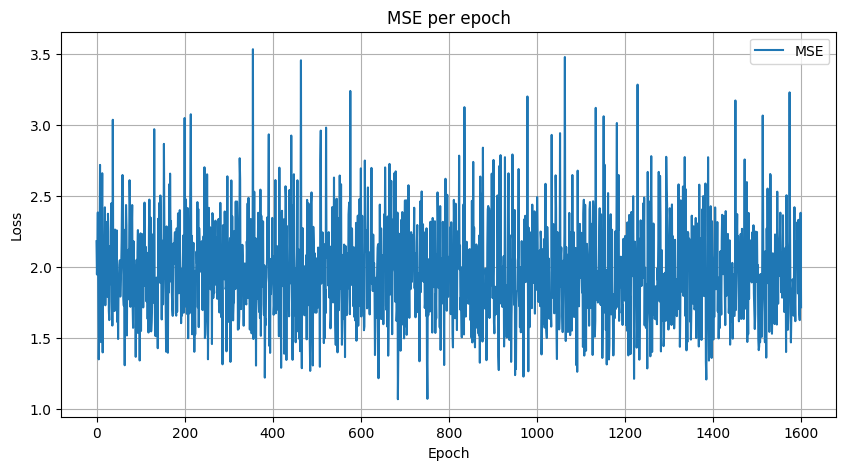

In [59]:
def plot_training_loss(training_losses):
    plt.figure(figsize=(10, 5))
    plt.plot(training_losses, label='MSE')
    plt.title('MSE per epoch')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)
    plt.savefig("mse_lstm.png")
    plt.show()
plot_training_loss(loss_result)

In [77]:
model.eval()  # Set the model to evaluation mode
all_predictions = [] 
all_labels = []
with torch.no_grad():  # No gradient tracking needed
    correct, total = 0, 0
    for inputs, labels in test_loader:
        outputs = model(inputs)
        #_, predicted = torch.max(outputs, 0)  # Thresholding at 0.5
        predicted = [math.ceil(i) for i in outputs.cpu().numpy()]
        all_predictions.extend(predicted)
        print(np.array(predicted))
        print(labels)
        total += labels.size(0)
        for i in range(len(labels)):
            if predicted[i] == labels[i]:
                correct += 1
        #correct += (np.array(predicted) == labels).sum().item()
        all_labels.extend(labels.cpu().numpy())
    print(f'Accuracy: {100 * correct / total}%')


[6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6
 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6]
tensor([7., 6., 6., 3., 6., 5., 4., 7., 6., 6., 6., 6., 5., 6., 6., 5., 5., 7.,
        6., 6., 6., 7., 5., 4., 5., 5., 4., 5., 8., 5., 6., 4., 6., 5., 6., 5.,
        6., 6., 5., 6., 7., 7., 6., 5., 7., 4., 5., 4., 6., 6., 7., 4., 5., 6.,
        7., 6., 5., 7., 5., 4., 5., 6., 5., 6.])
[6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6
 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6]
tensor([5., 6., 5., 6., 6., 5., 6., 6., 6., 6., 6., 6., 5., 6., 3., 6., 6., 6.,
        7., 4., 6., 5., 5., 6., 6., 6., 6., 6., 6., 6., 6., 7., 6., 6., 7., 6.,
        6., 3., 6., 6., 6., 5., 6., 6., 6., 6., 7., 7., 7., 5., 5., 5., 5., 7.,
        6., 4., 6., 6., 6., 5., 7., 6., 6., 7.])
[6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6
 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6]
tensor([6., 6., 6., 5., 6., 6

/tmp/ipykernel_25778/1623533834.py:9: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  predicted = [math.ceil(i) for i in outputs.cpu().numpy()]


In [40]:
def plot_confusion_matrix(y_p, y_t, labels):
    cm =  confusion_matrix(y_t, y_p, normalize='true', labels=labels)
    fig, ax = plt.subplots(figsize=(10, 10))
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
    disp.plot(cmap='Blues', values_format='.2f', ax=ax, colorbar=False)
    plt.title("Normalized confusion matrix")
    #plt.show()
    plt.savefig("lstm-result.png")
    

In [41]:
plot_confusion_matrix(all_predictions, all_labels, [i for i in range(10)])

In [42]:
model.eval()  # Set the model to evaluation mode
all_predictions = [] 
all_labels = []
with torch.no_grad():  # No gradient tracking needed
    correct, total = 0, 0
    for inputs, labels in train_loader:
        outputs = model(inputs)
        _, predicted = torch.max(outputs, 1)  # Thresholding at 0.5
        all_predictions.extend(predicted.cpu().numpy())
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        all_labels.extend(labels.cpu().numpy())
    print(f'Accuracy: {100 * correct / total}%')
    
def plot_confusion_matrix(y_p, y_t, labels):
    cm =  confusion_matrix(y_t, y_p, normalize='true', labels=labels)
    fig, ax = plt.subplots(figsize=(10, 10))
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
    disp.plot(cmap='Blues', values_format='.2f', ax=ax, colorbar=False)
    plt.title("Normalized confusion matrix")
    #plt.show()
    plt.savefig("lstm-result-training.png")

plot_confusion_matrix(all_predictions, all_labels, [i for i in range(10)])

Accuracy: 51.87376725838264%


In [33]:
!pip install optuna


[notice] A new release of pip is available: 23.2.1 -> 24.0
[notice] To update, run: pip install --upgrade pip


In [53]:
import optuna

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

def train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs):
    for epoch in range(num_epochs):
        model.train()
        for inputs, labels in train_loader:
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

        model.eval()
        val_loss = 0
        with torch.no_grad():
            for inputs, labels in val_loader:
                outputs = model(inputs)
                val_loss += criterion(outputs, labels).item()

        print(f'Epoch {epoch+1}, Validation Loss: {val_loss / len(val_loader)}')

def compute_validation_accuracy(model, val_loader):
    model.eval()  # Set the model to evaluation mode
    test_loss = 0
    with torch.no_grad():  # No need to compute gradient when evaluating
        for inputs, targets in test_loader:
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            test_loss += loss.item()
    
    return test_loss / len(test_loader)

def objective(trial):
    # Define hyperparameters
    num_layers = trial.suggest_int('num_layers', 1, 3)
    hidden_dim = trial.suggest_int('hidden_dim', 20, 50)
    lr = trial.suggest_loguniform('lr', 1e-4, 1e-1)

    model = MoodLSTMRegression(input_dim=19, hidden_dim=hidden_dim, output_dim=1, num_layers=num_layers)
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)

    train_model(model, train_loader, test_loader, criterion, optimizer, num_epochs=10)
    return -compute_validation_accuracy(model, test_loader)  # Define this function to compute accuracy

study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=10)
print("Best hyperparameters:", study.best_params)

[I 2024-04-20 16:22:36,683] A new study created in memory with name: no-name-d766b06d-4819-4417-916a-fc7f5643a774
/tmp/ipykernel_25778/1025635818.py:40: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform('lr', 1e-4, 1e-1)
[I 2024-04-20 16:22:36,850] Trial 0 finished with value: -1.0359133630990982 and parameters: {'num_layers': 1, 'hidden_dim': 37, 'lr': 0.0013144724544538714}. Best is trial 0 with value: -1.0359133630990982.


Epoch 1, Validation Loss: 32.06267738342285
Epoch 2, Validation Loss: 24.272176265716553
Epoch 3, Validation Loss: 9.849439144134521
Epoch 4, Validation Loss: 2.371155023574829
Epoch 5, Validation Loss: 1.0653984248638153
Epoch 6, Validation Loss: 1.0521530508995056
Epoch 7, Validation Loss: 1.0536258220672607
Epoch 8, Validation Loss: 1.0390756130218506
Epoch 9, Validation Loss: 1.035912424325943
Epoch 10, Validation Loss: 1.0359133630990982
Epoch 1, Validation Loss: 2.8160370588302612
Epoch 2, Validation Loss: 1.4965686202049255
Epoch 3, Validation Loss: 1.2163850367069244
Epoch 4, Validation Loss: 1.0547636598348618


[I 2024-04-20 16:22:36,996] Trial 1 finished with value: -1.0355956554412842 and parameters: {'num_layers': 1, 'hidden_dim': 29, 'lr': 0.01647330318556898}. Best is trial 1 with value: -1.0355956554412842.


Epoch 5, Validation Loss: 1.0415555834770203
Epoch 6, Validation Loss: 1.0463700741529465
Epoch 7, Validation Loss: 1.040023386478424
Epoch 8, Validation Loss: 1.040311336517334
Epoch 9, Validation Loss: 1.0358447432518005
Epoch 10, Validation Loss: 1.0355956554412842
Epoch 1, Validation Loss: 23.129271984100342
Epoch 2, Validation Loss: 5.028227090835571
Epoch 3, Validation Loss: 1.4871265292167664
Epoch 4, Validation Loss: 1.0389424711465836
Epoch 5, Validation Loss: 1.0484775006771088


[I 2024-04-20 16:22:37,245] Trial 2 finished with value: -1.0360080897808075 and parameters: {'num_layers': 3, 'hidden_dim': 32, 'lr': 0.0020242140491982304}. Best is trial 1 with value: -1.0355956554412842.


Epoch 6, Validation Loss: 1.0432712137699127
Epoch 7, Validation Loss: 1.0356713384389877
Epoch 8, Validation Loss: 1.0358968079090118
Epoch 9, Validation Loss: 1.0363542288541794
Epoch 10, Validation Loss: 1.0360080897808075
Epoch 1, Validation Loss: 1.2638042867183685
Epoch 2, Validation Loss: 1.3473827689886093
Epoch 3, Validation Loss: 1.1062262058258057


[I 2024-04-20 16:22:37,497] Trial 3 finished with value: -1.035688892006874 and parameters: {'num_layers': 3, 'hidden_dim': 23, 'lr': 0.012613199807704345}. Best is trial 1 with value: -1.0355956554412842.


Epoch 4, Validation Loss: 1.047534167766571
Epoch 5, Validation Loss: 1.0401220917701721
Epoch 6, Validation Loss: 1.0365008264780045
Epoch 7, Validation Loss: 1.036886528134346
Epoch 8, Validation Loss: 1.0376553535461426
Epoch 9, Validation Loss: 1.0357318371534348
Epoch 10, Validation Loss: 1.035688892006874
Epoch 1, Validation Loss: 1.2753620594739914
Epoch 2, Validation Loss: 1.1225264519453049
Epoch 3, Validation Loss: 1.0566152930259705


[I 2024-04-20 16:22:37,642] Trial 4 finished with value: -1.0361737459897995 and parameters: {'num_layers': 1, 'hidden_dim': 48, 'lr': 0.023303730132474717}. Best is trial 1 with value: -1.0355956554412842.


Epoch 4, Validation Loss: 1.0590849816799164
Epoch 5, Validation Loss: 1.0513710379600525
Epoch 6, Validation Loss: 1.085414081811905
Epoch 7, Validation Loss: 1.0370263755321503
Epoch 8, Validation Loss: 1.0595690310001373
Epoch 9, Validation Loss: 1.0363220274448395
Epoch 10, Validation Loss: 1.0361737459897995
Epoch 1, Validation Loss: 1.142215371131897
Epoch 2, Validation Loss: 1.193701520562172
Epoch 3, Validation Loss: 1.0583413243293762
Epoch 4, Validation Loss: 1.0706390738487244
Epoch 5, Validation Loss: 1.0649682581424713
Epoch 6, Validation Loss: 1.0619332790374756
Epoch 7, Validation Loss: 1.0851010382175446


[I 2024-04-20 16:22:37,787] Trial 5 finished with value: -1.0358343422412872 and parameters: {'num_layers': 1, 'hidden_dim': 37, 'lr': 0.030625271349324253}. Best is trial 1 with value: -1.0355956554412842.
[I 2024-04-20 16:22:37,932] Trial 6 finished with value: -1.0459981709718704 and parameters: {'num_layers': 1, 'hidden_dim': 48, 'lr': 0.00574579216914103}. Best is trial 1 with value: -1.0355956554412842.


Epoch 8, Validation Loss: 1.0616719722747803
Epoch 9, Validation Loss: 1.0658556073904037
Epoch 10, Validation Loss: 1.0358343422412872
Epoch 1, Validation Loss: 1.1148162186145782
Epoch 2, Validation Loss: 1.058145359158516
Epoch 3, Validation Loss: 1.0511747002601624
Epoch 4, Validation Loss: 1.0388668030500412
Epoch 5, Validation Loss: 1.0366731137037277
Epoch 6, Validation Loss: 1.0392507016658783
Epoch 7, Validation Loss: 1.0360836386680603
Epoch 8, Validation Loss: 1.0370542407035828
Epoch 9, Validation Loss: 1.035477802157402
Epoch 10, Validation Loss: 1.0459981709718704
Epoch 1, Validation Loss: 33.89566469192505


[I 2024-04-20 16:22:38,083] Trial 7 finished with value: -1.0392939448356628 and parameters: {'num_layers': 1, 'hidden_dim': 50, 'lr': 0.0004858831043824335}. Best is trial 1 with value: -1.0355956554412842.


Epoch 2, Validation Loss: 31.947828769683838
Epoch 3, Validation Loss: 28.262333869934082
Epoch 4, Validation Loss: 20.07534408569336
Epoch 5, Validation Loss: 8.774070262908936
Epoch 6, Validation Loss: 2.9974676370620728
Epoch 7, Validation Loss: 1.4314327239990234
Epoch 8, Validation Loss: 1.0968792140483856
Epoch 9, Validation Loss: 1.0421372950077057
Epoch 10, Validation Loss: 1.0392939448356628
Epoch 1, Validation Loss: 31.544960498809814
Epoch 2, Validation Loss: 20.979467391967773
Epoch 3, Validation Loss: 4.584949254989624
Epoch 4, Validation Loss: 1.0453800112009048
Epoch 5, Validation Loss: 1.1248997896909714


[I 2024-04-20 16:22:38,240] Trial 8 finished with value: -1.038962870836258 and parameters: {'num_layers': 1, 'hidden_dim': 47, 'lr': 0.0011905055945850148}. Best is trial 1 with value: -1.0355956554412842.


Epoch 6, Validation Loss: 1.0559046119451523
Epoch 7, Validation Loss: 1.0366513431072235
Epoch 8, Validation Loss: 1.0363397747278214
Epoch 9, Validation Loss: 1.0369217097759247
Epoch 10, Validation Loss: 1.038962870836258
Epoch 1, Validation Loss: 1.5377629399299622
Epoch 2, Validation Loss: 1.049355834722519
Epoch 3, Validation Loss: 1.0371553599834442
Epoch 4, Validation Loss: 1.0385662317276


[I 2024-04-20 16:22:38,529] Trial 9 finished with value: -1.0398400723934174 and parameters: {'num_layers': 3, 'hidden_dim': 35, 'lr': 0.04297800657052166}. Best is trial 1 with value: -1.0355956554412842.


Epoch 5, Validation Loss: 1.0993605852127075
Epoch 6, Validation Loss: 1.1469160914421082
Epoch 7, Validation Loss: 1.1217183768749237
Epoch 8, Validation Loss: 1.0519635528326035
Epoch 9, Validation Loss: 1.0394519120454788
Epoch 10, Validation Loss: 1.0398400723934174
Best hyperparameters: {'num_layers': 1, 'hidden_dim': 29, 'lr': 0.01647330318556898}
